# Figure 3. The overlap between splices identified by ONT sequencing and Illumina sequencing.

Code for making Figure 3 in the Nanopore DRS paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. For this figure we're focussing on two sets of data; first, four biological replicates of WT col-0 tissue sequenced with ONT Direct RNA Sequencing and second, seven biological replicates of WT col-0 tissue sequenced with Illumina Tru-Seq Ribo-zero Gold 100bp PE sequencing.

This figure is here to illuminate the support for the uniques splices observed in the ONT DRS datasets, broken down by whether they are also detected in the Illumina data and the araport and AtRTD2 annotations.

*Note: pyupset requires a specific install of python, so make sure this notebook is running in the right conda env*

In [1]:
import re, os, sys, pysam, json, matplotlib, numpy
%matplotlib inline
import matplotlib.pyplot as plt
from snakemake.io import expand
from Bio import SeqIO
import pyupset as pyu
import pandas as pd
matplotlib.__version__

'2.0.2'

In [2]:
rootpath = "/cluster/gjb_lab/nschurch/Projects"
illumina_root = "Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col"
drs_root = "Arabidopsis_MinION_Datasets"

illumina_datasets = expand("{groot}/{iroot}/Col-{rep}/{strand}_splicing_splice_stats.json",
                           rep=[1,2,3,4,5,6,7], strand=["fwd","rev"], groot=rootpath, iroot=illumina_root)

drs_datasets_list = [("20180201_col0_run008_tissue2916","20180201_col0_run008_splice_stats.json"),
                     ("20180405_col0_run010_tissue2917","201804_col0_tissue2917_splice_stats.json"),
                     ("20180413_col0_run012_tissue2917","201804_col0_run012_2917_splice_stats.json"),
                     ("20180416_col0_run013_tissue2918","201804_col0_run013_2918_splice_stats.json"),
                     ("20180418_col0_run014_tissue2919","201804_col0_run014_2919_splice_stats.json")]

minION_datasets = expand("{groot}/{iroot}/{datasets[0]}/albacore_2.2.7/stats/splicing/TAIR10/{datasets[1]}",
                         datasets=drs_datasets_list, groot=rootpath, iroot=drs_root)

In [3]:
def getSplicingDicts(datasets):
    splicing = {"canonical":{}, "noncanonical":{}}
    ds_count={}
    for dataset in datasets:
        these_splices = json.load(open(dataset,"r"))
        ds_count[dataset] = len(these_splices.keys())
        print("parsing {} splices from dataset {}...".format(len(these_splices.keys()),dataset))
        for splicepos in these_splices.keys():
            if these_splices[splicepos]['is_canonical']:
                key = "canonical"
            else:
                key = "noncanonical"         
            
            thismotif = "".join(these_splices[splicepos]['sites'])
            
            try:
                splicing[key][splicepos][thismotif] += len(these_splices[splicepos]["reads"])
            except KeyError:
                if splicepos not in splicing[key].keys():
                    splicing[key][splicepos] = {thismotif:len(these_splices[splicepos]["reads"])}
                else:
                    splicing[key][splicepos][thismotif] = len(these_splices[splicepos]["reads"])
    
    print("\n{} unique canonical splices.".format(len(splicing["canonical"].keys())))
    print("{} unique non-canonical splices.\n".format(len(splicing["noncanonical"].keys())))
    return(splicing, ds_count)

In [4]:
illumina_unique_splices, illumina_ds_splicecounts = getSplicingDicts(illumina_datasets)

parsing 69475 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col/Col-1/fwd_splicing_splice_stats.json...
parsing 70293 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col/Col-1/rev_splicing_splice_stats.json...
parsing 69444 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col/Col-2/fwd_splicing_splice_stats.json...
parsing 70033 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col/Col-2/rev_splicing_splice_stats.json...
parsing 68363 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col/Col-3/fwd_splicing_splice_stats.json...
parsing 69217 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col/Col-3/rev_splicing_splice_stats.json...
parsing 58231 splices from dataset /cluster/gjb_lab/nschur

In [5]:
drs_unique_splices, drs_ds_splicecounts = getSplicingDicts(minION_datasets)

parsing 154773 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180201_col0_run008_tissue2916/albacore_2.2.7/stats/splicing/TAIR10/20180201_col0_run008_splice_stats.json...
parsing 145865 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180405_col0_run010_tissue2917/albacore_2.2.7/stats/splicing/TAIR10/201804_col0_tissue2917_splice_stats.json...
parsing 151503 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180413_col0_run012_tissue2917/albacore_2.2.7/stats/splicing/TAIR10/201804_col0_run012_2917_splice_stats.json...
parsing 138414 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180416_col0_run013_tissue2918/albacore_2.2.7/stats/splicing/TAIR10/201804_col0_run013_2918_splice_stats.json...
parsing 137571 splices from dataset /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180418_col0_run014_tissue2919/albacore_2.2.7/stats/

OK so I want to compare these sets of unique splices with each other and with the introns from both the araport 11 and AtRTD2 annotation. So now I need to load the annotation, parse out the introns and classify them as canonical or not...

In [6]:
a11_path = "{}/Arabidopsis_annotations/TAIR10/ensembl/release_35".format(rootpath)
atrtd2_path = "{}/Arabidopsis_annotations/atRTD/2016_update".format(rootpath)

# load the genome
genome = {}
for seq_record in SeqIO.parse("{}/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa".format(a11_path), "fasta"):
    genome[seq_record.name] = seq_record

In [7]:
from parsing_routines.gff_gtf_tools import annotation
from parsing_routines.general_classes_and_functions import computeIntrons

def getAnnotationIntrons(annot, genome, chr_synonym_dic={}, parent_key="parent",
                         LOG_EVERY_N=10000):
    
    """ return a dictionary with all the introns in a given annotation """
    
    annot.clear_all()
    annot.set_feature("exons")
    exons = annot.get_selection()
    tx_exons={}
    for exon in exons:
        if type(exon.desc[parent_key]) is list:
            for parent in exon.desc[parent_key]:
                try:
                    tx_exons[parent].append(exon)
                except KeyError:
                    tx_exons[parent]=[exon]
        else:
            try:
                tx_exons[exon.desc[parent_key]].append(exon)
            except KeyError:
                tx_exons[exon.desc[parent_key]]=[exon]
    
    splice_details={}
    nlogs=1
    counter=0
    for transcript in tx_exons.keys():
        these_introns = computeIntrons(tx_exons[transcript], parent_key=parent_key, logger=None)
        for intron in these_introns:
            donor_splice_site=None
            acceptor_splice_site=None
            
            this_chrid = intron.chrid
            if intron.chrid not in genome.keys():
                if intron.chrid in chr_synonym_dic.keys() and chr_synonym_dic[intron.chrid] in genome.keys():
                    this_chrid = chr_synonym_dic[intron.chrid]
                else:
                    msg = "There is a mismatch between the annotation and " \
                          "genome chromosome IDs that is not accounted for " \
                          "in the provided chromosome synonyms list. Details: " \
                          "Annotation ID: {}, genome IDs: {}, synonyms: {} " \
                          "".format(intron.chrid, genome.keys(), chr_synonym_dic)
                    raise ValueError(msg)
            
            if intron.strand=="-":
                donor_splice_site = genome[this_chrid][intron.stop-2:intron.stop].reverse_complement()
                acceptor_splice_site = genome[this_chrid][intron.start-1:intron.start+1].reverse_complement()
            else:
                acceptor_splice_site = genome[this_chrid][intron.stop-2:intron.stop]
                donor_splice_site = genome[this_chrid][intron.start-1:intron.start+1]
            
            keystr = "{}:{}-{}".format(intron.chrid,
                                       intron.start-1,
                                       intron.stop)
            
            try:
                splice_details[keystr]["transcripts"].append(transcript)
            except:
                splice_details[keystr]={"transcripts":[transcript],
                                        "sites":(str(donor_splice_site.seq),
                                                 str(acceptor_splice_site.seq))}
                if donor_splice_site.seq!="GT" or acceptor_splice_site.seq!="AG":
                    splice_details[keystr]["is_canonical"]=False
                else:
                    splice_details[keystr]["is_canonical"]=True
        
        counter+=1
        
        if (counter % LOG_EVERY_N)==0:
            msg="processed {these} transcripts...".format(these=(nlogs*LOG_EVERY_N))
            print(msg)
            nlogs+=1
    
    return(splice_details)

In [8]:
# load the Araport 11 annotation
a11 = annotation("{}/Arabidopsis_thaliana.TAIR10.35.gff3".format(a11_path), filetype="gff3", stripChr=False)
chr_synonym_dic = {"C":"Pt","M":"Mt"}
a11_introns = getAnnotationIntrons(a11, genome, chr_synonym_dic)
a11_defintrons={"canonical":{}, "noncanonical":{}}
for intron in a11_introns.keys():
    if a11_introns[intron]['is_canonical']:
        a11_defintrons["canonical"][intron]=a11_introns[intron]
    else:
        a11_defintrons["noncanonical"][intron]=a11_introns[intron]

processed 10000 transcripts...
processed 20000 transcripts...
processed 30000 transcripts...
processed 40000 transcripts...
processed 50000 transcripts...


In [9]:
# load the AtRTD2 annotation
atrtd2 = annotation("{}/AtRTD2_19April2016.gtf".format(atrtd2_path), filetype="gtf", stripChr=True)
atrtd2_introns = getAnnotationIntrons(atrtd2, genome, chr_synonym_dic, parent_key="transcript_id")
atrtd2_defintrons={"canonical":{}, "noncanonical":{}}
for intron in atrtd2_introns.keys():
    if atrtd2_introns[intron]['is_canonical']:
        atrtd2_defintrons["canonical"][intron]=atrtd2_introns[intron]
    else:
        atrtd2_defintrons["noncanonical"][intron]=atrtd2_introns[intron]

processed 10000 transcripts...
processed 20000 transcripts...
processed 30000 transcripts...
processed 40000 transcripts...
processed 50000 transcripts...
processed 60000 transcripts...
processed 70000 transcripts...
processed 80000 transcripts...


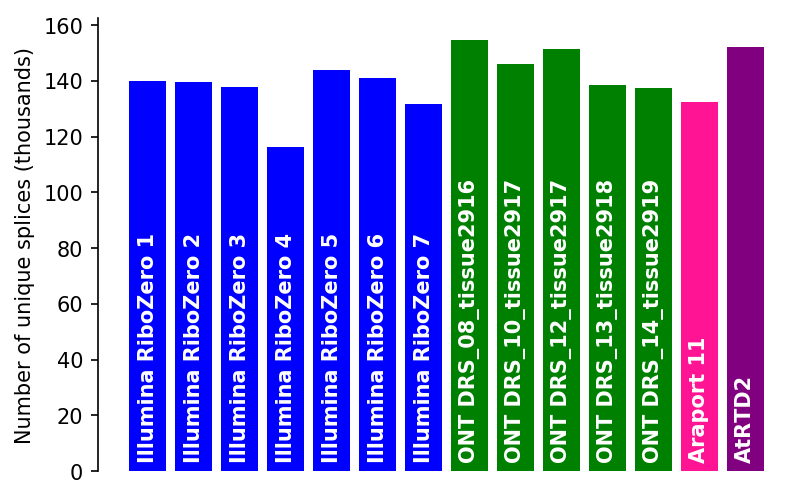

In [62]:
# plot the total splicing complement in each annotation and data file
plotnames=[]
plotvalues=[]
plotcol=[]

illdslist = sorted(list(illumina_ds_splicecounts.keys()))
illreplist = []
for ds in illdslist:
    illreplist.append(os.path.dirname(ds).split("/")[-1])

basedir = "/cluster/gjb_lab/nschurch/Projects/Arabidopsis_RNAMeth/STAR_alignments/TAIR10/Col/"
filesub = "_splicing_splice_stats.json"
#print("Illumina dataset unique splice counts:")
col="blue"
for dataset in sorted(list(set(illreplist))):
    count = illumina_ds_splicecounts[os.path.join(basedir, dataset, "fwd{}".format(filesub))]+illumina_ds_splicecounts[os.path.join(basedir, dataset, "rev{}".format(filesub))]
    #print("\t{:>45}:{:8d}".format(dataset,count))
    plotnames.append(re.sub("Col-","Illumina RiboZero ", dataset))
    plotvalues.append(count)
    plotcol.append(col)

col="green"
#print("\nONT DRS dataset unique splice counts:")
for dataset in sorted(list(drs_ds_splicecounts.keys())):
    run=re.match(".+_run0([0-9]+_tissue[0-9]+)/.+", dataset)
    #print("\t{:>45}:{:>8d}".format(os.path.basename(dataset), drs_ds_splicecounts[dataset]))
    plotnames.append("ONT DRS_{}".format(run.group(1)))
    plotvalues.append(drs_ds_splicecounts[dataset])
    plotcol.append(col)
    
#print("\nAnnotation unique splice counts:")
#print("\t{:>45}:{:>8d}".format("Araport 11", len(a11_defintrons["canonical"])+len(a11_defintrons["noncanonical"])))
#print("\t{:>45}:{:>8d}".format("AtRTD2", len(atrtd2_defintrons["canonical"])+len(atrtd2_defintrons["noncanonical"])))
plotnames.append("Araport 11")
plotvalues.append(len(a11_defintrons["canonical"])+len(a11_defintrons["noncanonical"]))
plotcol.append("deeppink")
                     
plotnames.append("AtRTD2")
plotvalues.append(len(atrtd2_defintrons["canonical"])+len(atrtd2_defintrons["noncanonical"]))
plotcol.append("purple")

plotvalues = numpy.array(plotvalues)/1000

fig=plt.figure(figsize=(6,4), dpi=150)
plt.bar(numpy.arange(len(plotvalues)), plotvalues, color=plotcol)
ax=plt.gca()
plt.setp(ax.get_xticklabels(), visible=False)
ax.xaxis.set_tick_params(size=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
id=0
for name in plotnames:
    plt.text(id, 3, name, color="white", rotation=90, horizontalalignment='center', verticalalignment='bottom', weight='bold')
    id+=1
plt.ylabel("Number of unique splices (thousands)")
plt.savefig("/cluster/gjb_lab/nschurch/new_cluster_workspace/ONTdrstools/Paper figures/Figure6.png",
           format='png', transparent=True, bbox_inches='tight', frameon=False)

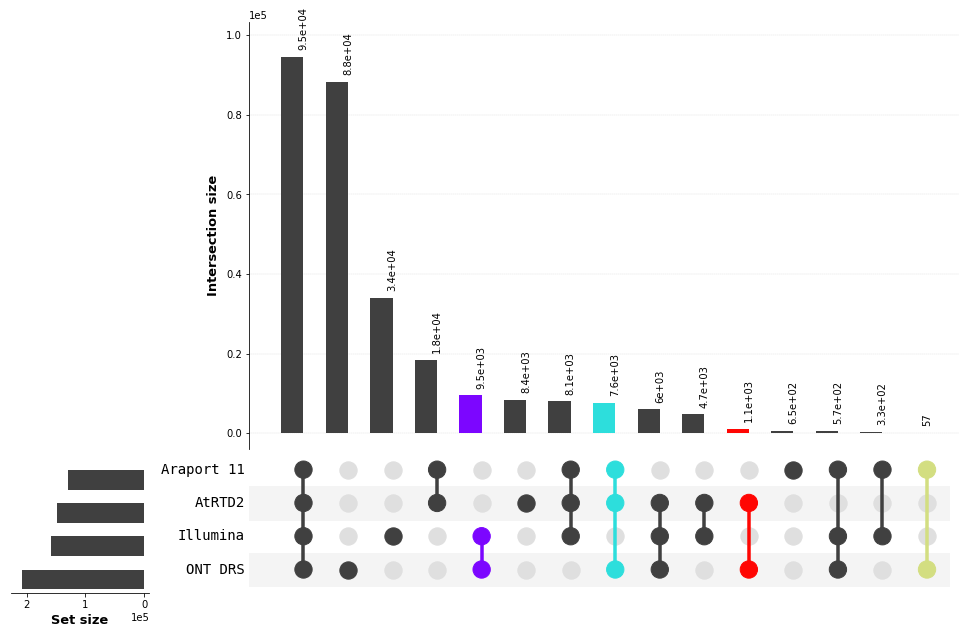

In [63]:
canonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["canonical"].keys())),
                  "ONT DRS":pd.DataFrame(list(drs_unique_splices["canonical"].keys())),
                  "Araport 11":pd.DataFrame(list(a11_defintrons["canonical"].keys())),
                  "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["canonical"].keys()))}
canonical_upset = pyu.plot(canonical_comp, sort_by='size',
                           query = [('Illumina', 'ONT DRS'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2')])

plt.savefig("/cluster/gjb_lab/nschurch/new_cluster_workspace/ONTdrstools/Paper figures/Figure3a.svg",
           format='svg', transparent=True, bbox_inches='tight', frameon=False)

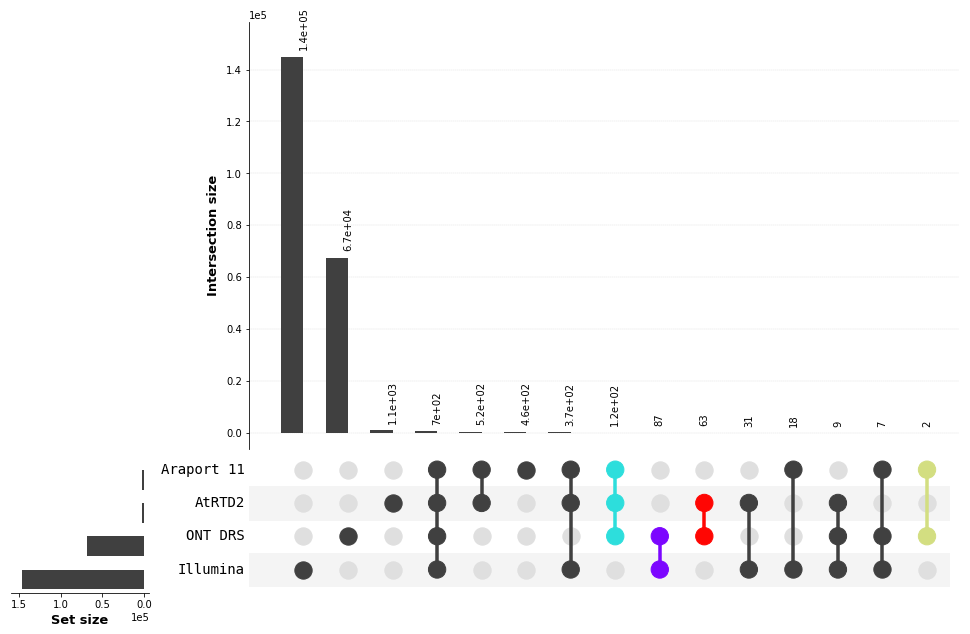

In [64]:
noncanonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["noncanonical"].keys())),
                     "ONT DRS":pd.DataFrame(list(drs_unique_splices["noncanonical"].keys())),
                     "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                     "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_upset = pyu.plot(noncanonical_comp, sort_by='size', query = [('Illumina', 'ONT DRS'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2')])

plt.savefig("/cluster/gjb_lab/nschurch/new_cluster_workspace/ONTdrstools/Paper figures/Figure3b.svg",
           format='svg', transparent=True, bbox_inches='tight', frameon=False)

In [65]:
common_columns = []
for i, k in enumerate(canonical_comp.keys()):
    if i == 0:
        common_columns = canonical_comp[k].columns
    else:
        common_columns = common_columns.intersection(canonical_comp[k].columns)
x=pyu.visualisation.DataExtractor(canonical_comp, common_columns)

In [66]:
for key in x.inters_df_dict.keys():
    print(key, len(x.inters_df_dict[key]))

frozenset({'ONT DRS'}) 88365
frozenset({'Illumina'}) 34031
frozenset({'AtRTD2'}) 8423
frozenset({'Araport 11'}) 651
frozenset({'Illumina', 'ONT DRS'}) 9535
frozenset({'AtRTD2', 'ONT DRS'}) 1115
frozenset({'Araport 11', 'ONT DRS'}) 57
frozenset({'Illumina', 'AtRTD2'}) 4731
frozenset({'Illumina', 'Araport 11'}) 328
frozenset({'AtRTD2', 'Araport 11'}) 18409
frozenset({'Illumina', 'AtRTD2', 'ONT DRS'}) 6020
frozenset({'Illumina', 'Araport 11', 'ONT DRS'}) 573
frozenset({'AtRTD2', 'Araport 11', 'ONT DRS'}) 7644
frozenset({'Illumina', 'AtRTD2', 'Araport 11'}) 8057
frozenset({'Illumina', 'AtRTD2', 'Araport 11', 'ONT DRS'}) 94613


In [67]:
i=0
while i<len(x.ordered_dfs):
    print(x.ordered_df_names[i], len(x.ordered_dfs[i]))
    i+=1

ONT DRS 207922
Illumina 157888
AtRTD2 149012
Araport 11 130332


In [68]:
common_columns = []
for i, k in enumerate(noncanonical_comp.keys()):
    if i == 0:
        common_columns = noncanonical_comp[k].columns
    else:
        common_columns = common_columns.intersection(noncanonical_comp[k].columns)
y=pyu.visualisation.DataExtractor(noncanonical_comp, common_columns)

In [69]:
for key in y.inters_df_dict.keys():
    print(key, len(y.inters_df_dict[key]))

frozenset({'Illumina'}) 144973
frozenset({'ONT DRS'}) 67492
frozenset({'AtRTD2'}) 1124
frozenset({'Araport 11'}) 461
frozenset({'Illumina', 'ONT DRS'}) 87
frozenset({'Illumina', 'AtRTD2'}) 31
frozenset({'Illumina', 'Araport 11'}) 18
frozenset({'AtRTD2', 'ONT DRS'}) 63
frozenset({'Araport 11', 'ONT DRS'}) 2
frozenset({'AtRTD2', 'Araport 11'}) 521
frozenset({'Illumina', 'AtRTD2', 'ONT DRS'}) 9
frozenset({'Illumina', 'Araport 11', 'ONT DRS'}) 7
frozenset({'Illumina', 'AtRTD2', 'Araport 11'}) 366
frozenset({'AtRTD2', 'Araport 11', 'ONT DRS'}) 119
frozenset({'Illumina', 'AtRTD2', 'Araport 11', 'ONT DRS'}) 698


In [70]:
i=0
while i<len(y.ordered_dfs):
    print(y.ordered_df_names[i], len(y.ordered_dfs[i]))
    i+=1

Illumina 146189
ONT DRS 68477
AtRTD2 2931
Araport 11 2192


# Calculating some set numbers for the paper...

Lets start by calculating the number of unique splices in the ONT DRS data that are also in either annotation...

In [94]:
keyName = 'Araport 11'

count=0
for key in x.inters_df_dict.keys():
    if 'ONT DRS' in key and keyName in key:
        count+=len(x.inters_df_dict[key])
for key in y.inters_df_dict.keys():
    if 'ONT DRS' in key and keyName in key:
        count+=len(y.inters_df_dict[key])

acount = len(x.ordered_dfs[numpy.where(x.ordered_df_names==keyName)[0][0]])+len(y.ordered_dfs[numpy.where(y.ordered_df_names==keyName)[0][0]])
print("Unique spliced in ONT DRS and in {}: {} ({:.2f}%)".format(keyName, count, 100*float(count)/acount))

Unique spliced in ONT DRS and in Araport 11: 103713 (78.26%)


In [95]:
keyName = 'AtRTD2'

count=0
for key in x.inters_df_dict.keys():
    if 'ONT DRS' in key and keyName in key:
        count+=len(x.inters_df_dict[key])
for key in y.inters_df_dict.keys():
    if 'ONT DRS' in key and keyName in key:
        count+=len(y.inters_df_dict[key])

acount = len(x.ordered_dfs[numpy.where(x.ordered_df_names==keyName)[0][0]])+len(y.ordered_dfs[numpy.where(y.ordered_df_names==keyName)[0][0]])
print("Unique spliced in ONT DRS and in {}: {} ({:.2f}%)".format(keyName, count, 100*float(count)/acount))

Unique spliced in ONT DRS and in AtRTD2: 110281 (72.58%)


In [96]:
count=0
for key in x.inters_df_dict.keys():
    if 'ONT DRS' in key and ('Araport 11' in key or 'AtRTD2' in key) and 'Illumina' not in key:
        count+=len(x.inters_df_dict[key])
for key in y.inters_df_dict.keys():
    if 'ONT DRS' in key and ('Araport 11' in key or 'AtRTD2' in key) and 'Illumina' not in key:
        count+=len(y.inters_df_dict[key])

print("Unique spliced in ONT DRS and either annotation, but not in Illumina: ", count)

Unique spliced in ONT DRS and either annotation, but not in Illumina:  9000


In [107]:
count=0
for key in x.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Araport 11' in key and 'AtRTD2' not in key and 'Illumina' not in key:
        count+=len(x.inters_df_dict[key])
    if 'ONT DRS' in key and 'Araport 11' not in key and 'AtRTD2' in key and 'Illumina' not in key:
        count+=len(x.inters_df_dict[key])

for key in y.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Araport 11' in key and 'AtRTD2' not in key and 'Illumina' not in key:
        count+=len(y.inters_df_dict[key])
    if 'ONT DRS' in key and 'Araport 11' not in key and 'AtRTD2' in key and 'Illumina' not in key:
        count+=len(y.inters_df_dict[key])

print("Unique spliced in ONT DRS and either annotation, but not in both and not in Illumina: ", count)

Unique spliced in ONT DRS and either annotation, but not in both and not in Illumina:  1237


In [109]:
count=0
for key in x.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Illumina' in key and 'Araport 11' not in key and 'AtRTD2' not in key:
        count+=len(x.inters_df_dict[key])
    
for key in y.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Illumina' in key and 'Araport 11' not in key and 'AtRTD2' not in key:
        count+=len(y.inters_df_dict[key])
    
print("Unique spliced in ONT DRS, not in either annotation, but also in Illumina: ", count)

Unique spliced in ONT DRS, not in either annotation, but also in Illumina:  9622


In [114]:
count=0
count2=0
for key in x.inters_df_dict.keys():
    if 'ONT DRS' in key:
        if len(key)==1:
            count+=len(x.inters_df_dict[key])
        else:
            count2+=len(x.inters_df_dict[key])
    
for key in y.inters_df_dict.keys():
    if 'ONT DRS' in key:
        if len(key)==1:
            count+=len(y.inters_df_dict[key])
        else:
            count2+=len(y.inters_df_dict[key])
    
print("Unique splices in ONT DRS that are *only* in the ONT DRS data: {} ({:.2f}%)".format(count, 100*float(count)/(count2+count)))

Unique splices in ONT DRS that are *only* in the ONT DRs data: 155857 (56.39%)


In [115]:
count=0
count2=0
for key in x.inters_df_dict.keys():
    if 'Illumina' in key:
        if len(key)==1:
            count+=len(x.inters_df_dict[key])
        else:
            count2+=len(x.inters_df_dict[key])
    
for key in y.inters_df_dict.keys():
    if 'Illumina' in key:
        if len(key)==1:
            count+=len(y.inters_df_dict[key])
        else:
            count2+=len(y.inters_df_dict[key])
    
print("Unique splices in Illumina that are *only* in the Illumina data: {} ({:.2f}%)".format(count, 100*float(count)/(count2+count)))

Unique splices in Illumina that are *only* in the Illumina data: 179004 (58.87%)
